# 掛載雲端硬碟

In [440]:
# import os
# from google.colab import drive

# drive.mount('/content/drive')

# os.chdir('/content/drive/MyDrive/Colab Notebooks/AI_CUP_DemoCode/TrainingData/')

# 載入套件

In [441]:
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

# 模型架構

In [442]:
# default hyperparameters
NEURONS = 300
HIDDEN_LAYERS = 3

# def create_DNN(input_shape, neurons = NEURONS, hidden_layers = HIDDEN_LAYERS, learning_rate = 0.001, verbose=0):
#     model = Sequential()

#     model.add(Dense(neurons, input_dim=input_shape))
#     model.add(Activation('relu'))

#     for i in range(hidden_layers-1):
#         model.add(Dense(neurons))
#         model.add(Activation('relu'))
#         model.add(Dropout(0.2))

#     model.add(Dense(5))
#     model.add(Activation('softmax'))

#     opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # categorical_crossentropy

#     if verbose:
#         model.summary()
    
#     return model


def create_DNN(input_shape, learning_rate = 0.001, dropout_rate = 0.2, verbose=0):
    model = Sequential()

    model.add(Dense(512, input_dim=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(256, input_dim=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(128, input_dim=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(64, input_dim=input_shape))
    model.add(Activation('selu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32, input_dim=input_shape))
    model.add(Activation('selu'))
    model.add(Dropout(dropout_rate))
    

    
    model.add(Dense(5))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # categorical_crossentropy

    if verbose:
        model.summary()
    
    return model

# 載入訓練資料

In [443]:
# 讀取訓練資料集表單
source_df = pd.read_csv('./Training_Dataset/training_datalist.csv')

print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


# 資料前處理

In [444]:
def medical_data_proccessing(df):
    medical_col = ['Sex', 'Age', 'Narrow pitch range',
                'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
                'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
                'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
                'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
                'Head and Neck Cancer', 'Head injury', 'CVA',
                'Voice handicap index - 10', 'Disease category']
    
    # 選定要訓練預測的類別
    df = df.loc[df['Disease category'].isin([1, 2, 3, 4, 5]), medical_col]

    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    df['Age'] = df['Age'] / 50
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40

    return df

In [445]:
source_df = medical_data_proccessing(source_df)

print("Disease category in training_df :", source_df['Disease category'].unique())
print("training_df col :", source_df.columns)
print("training_df shape :", source_df.shape)

Disease category in training_df : [1 2 3 5 4]
training_df col : Index(['Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10', 'Disease category'],
      dtype='object')
training_df shape : (1000, 27)


## 訓練與驗證資料切分

In [446]:
training_df, test_df = train_test_split(source_df, test_size=0.2, random_state=333)

print("training_df shape :", training_df.shape, ", test_df shape :", test_df.shape)

training_df shape : (800, 27) , test_df shape : (200, 27)


In [447]:
# 訓練資料標記轉換
training_data = training_df.iloc[:, :-1]
training_data['c1'] = training_df['Disease category'].map({1:1, 2:0, 3:0, 4:0, 5:0})
training_data['c2'] = training_df['Disease category'].map({1:0, 2:1, 3:0, 4:0, 5:0})
training_data['c3'] = training_df['Disease category'].map({1:0, 2:0, 3:1, 4:0, 5:0})
training_data['c4'] = training_df['Disease category'].map({1:0, 2:0, 3:0, 4:1, 5:0})
training_data['c5'] = training_df['Disease category'].map({1:0, 2:0, 3:0, 4:0, 5:1})

print("training_data.shape :", training_data.shape)

x_train = training_data.iloc[:, :-5]
y_train = training_data.iloc[:, -5:]
print("x_train.shape, y_train.shape :", x_train.shape, y_train.shape)
print("y_train.columns :", y_train.columns.tolist())

training_data.shape : (800, 31)
x_train.shape, y_train.shape : (800, 26) (800, 5)
y_train.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [448]:
# 驗證資料標記轉換
test_data = test_df.iloc[:, :-1]
test_data['c1'] = test_df['Disease category'].map({1:1, 2:0, 3:0, 4:0, 5:0})
test_data['c2'] = test_df['Disease category'].map({1:0, 2:1, 3:0, 4:0, 5:0})
test_data['c3'] = test_df['Disease category'].map({1:0, 2:0, 3:1, 4:0, 5:0})
test_data['c4'] = test_df['Disease category'].map({1:0, 2:0, 3:0, 4:1, 5:0})
test_data['c5'] = test_df['Disease category'].map({1:0, 2:0, 3:0, 4:0, 5:1})

print("test_data.shape :", test_data.shape)

x_val = test_data.iloc[:, :-5]
y_val = test_data.iloc[:, -5:]
print("x_val.shape, y_val.shape :", x_val.shape, y_val.shape)
print("y_val.columns :", y_val.columns.tolist())

test_data.shape : (200, 31)
x_val.shape, y_val.shape : (200, 26) (200, 5)
y_val.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


# 訓練病理特徵

In [449]:
model = create_DNN(input_shape = x_train.shape[1], verbose=1)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 512)               13824     
                                                                 
 activation_172 (Activation)  (None, 512)              0         
                                                                 
 dropout_107 (Dropout)       (None, 512)               0         
                                                                 
 dense_173 (Dense)           (None, 256)               131328    
                                                                 
 activation_173 (Activation)  (None, 256)              0         
                                                                 
 dropout_108 (Dropout)       (None, 256)               0         
                                                                 
 dense_174 (Dense)           (None, 128)             

In [450]:
MODEL_SAVE_NAME = "AI_CUP_medical_sample_model"

train_results = model.fit(x_train, y_train, batch_size=None, epochs=100, 
                              callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='auto'),
                                         ModelCheckpoint(MODEL_SAVE_NAME+".h5", save_best_only=True)], 
                              validation_data=(x_val, y_val))

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 1.3478 - accuracy: 0.4725 - val_loss: 1.0195 - val_accuracy: 0.6100
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 1.1455 - accuracy: 0.5550 - val_loss: 0.8815 - val_accuracy: 0.6950
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 1.0905 - accuracy: 0.5838 - val_loss: 0.8488 - val_accuracy: 0.7250
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 1.0449 - accuracy: 0.6125 - val_loss: 0.8149 - val_accuracy: 0.7050
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9932 - accuracy: 0.6350 - val_loss: 0.8172 - val_accuracy: 0.7050
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9823 - accuracy: 0.6263 - val_loss: 0.8210 - val_accuracy: 0.7000
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.9192 - accuracy: 0.6538 - val_loss: 0.8043 - val_accuracy: 0.7100
Epoch 8/100


## 訓練資料

25/25 [==============================] - 0s 1ms/step
Training UAR(Unweighted Average Recall) : 0.8009547437004805


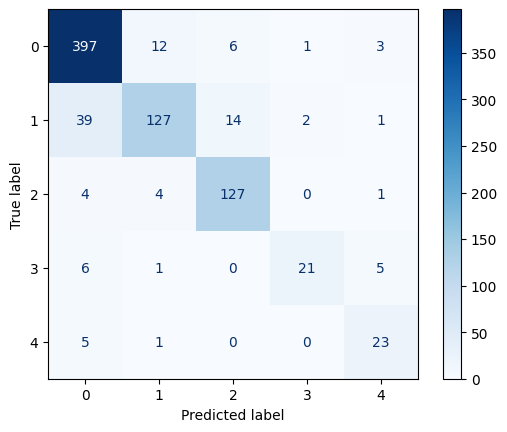

In [451]:
y_pred = model.predict(training_df.iloc[:, :-1]).argmax(axis=1)
y_true = training_df['Disease category'] - 1

results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

# 驗證資料測試結果

7/7 [==============================] - 0s 2ms/step
Test UAR(Unweighted Average Recall) : 0.4499371311871312


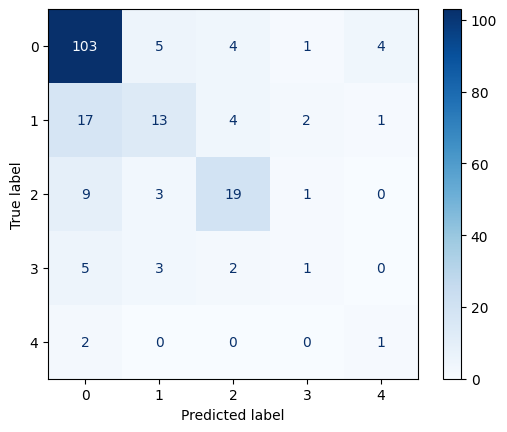

In [452]:
y_pred = model.predict(test_df.iloc[:, :-1]).argmax(axis=1)
y_true = test_df['Disease category'] - 1

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

#0.47 中間改relu dropout(0.2)